In [231]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [232]:
folder = 'C:\\Users\\saket\\OneDrive\\Desktop\\SOC_project\\drowsiness_detection'
classes = ['C:\\Users\\saket\\OneDrive\\Desktop\\SOC_project\\drowsiness_detection\\Open_Eyes','C:\\Users\\saket\\OneDrive\\Desktop\\SOC_project\\drowsiness_detection\\Closed_Eyes']

train_data = []

for i in classes:
    path = os.path.join(folder,i)
    class_num = classes.index(i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        rgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        new_array = cv2.resize(rgb,(224,224))      #resizing images to 224*224
        train_data.append([new_array,class_num])

In [233]:
random.shuffle(train_data)

In [234]:
im = []
ctg = []

for i,j in train_data:
    im.append(i)
    ctg.append(j)


im = np.array(im).reshape(-1,224,224,3)
ctg = np.array(ctg)

In [235]:
im.shape

(4000, 224, 224, 3)

In [236]:
#normalizing data
im = im/255.0

In [11]:
#We use Pickle for serialization

pickle_out = open('im.pickle','wb')
pickle.dump(im,pickle_out)
pickle_out.close

pickle_out = open('ctg.pickle', 'wb')
pickle.dump(ctg,pickle_out)
pickle_out.close

<function BufferedWriter.close>

In [237]:
#for opening
pickle_in = open('im.pickle','rb')
im = pickle.load(pickle_in)

pickle_in = open('ctg.pickle','rb')
ctg = pickle.load(pickle_in)

In [238]:
# Now we build the model

model = tf.keras.applications.mobilenet.MobileNet()

In [239]:
#We can see the layers present in the model
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [240]:
#Now we perform Transfer Learning on the model

base_input = model.layers[0].input
base_output = model.layers[-4].output

In [241]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(flat_layer)
final_op = layers.Activation('sigmoid')(final_output)

In [242]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [243]:
new_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [245]:
new_model.fit(im, ctg, epochs = 5, validation_split = 0.1)

Epoch 1/5
113/113 [==============================] - 630s 6s/step - loss: 0.1172 - accuracy: 0.9908 - val_loss: 0.8073 - val_accuracy: 0.9450
Epoch 2/5
113/113 [==============================] - 576s 5s/step - loss: 0.1241 - accuracy: 0.9914 - val_loss: 1.6038 - val_accuracy: 0.8925
Epoch 3/5
113/113 [==============================] - 648s 6s/step - loss: 0.9331 - accuracy: 0.9369 - val_loss: 0.5844 - val_accuracy: 0.9575
Epoch 4/5
113/113 [==============================] - 637s 6s/step - loss: 1.3375 - accuracy: 0.9100 - val_loss: 2.8035 - val_accuracy: 0.8175
Epoch 5/5
113/113 [==============================] - 615s 5s/step - loss: 0.0906 - accuracy: 0.9936 - val_loss: 2.4709 - val_accuracy: 0.8375


In [246]:
new_model.save('dd_final_model.h5')

In [247]:
new_model = tf.keras.models.load_model('dd_final_model.h5')

In [255]:
#Checking the predictions on eye images

img = cv2.imread('C:\\Users\\saket\\Downloads\\Some Images to test\\closed_test_2.png', cv2.IMREAD_GRAYSCALE)
rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
new = cv2.resize(rgb , (224,224))

In [256]:
x_input = np.array(new).reshape(1,224,224,3)

In [257]:
x_input.shape

(1, 224, 224, 3)

In [258]:
x_input = x_input/255.0

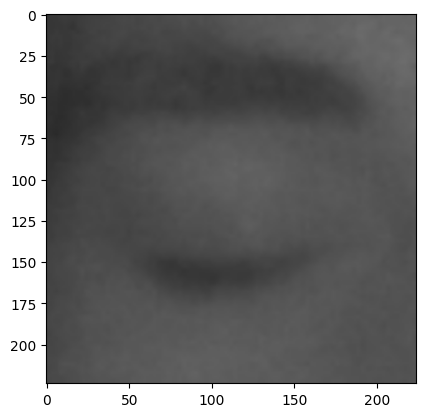

In [259]:
plt.imshow(new)

In [260]:
prediction = new_model.predict(x_input)

1/1 [==============================] - 0s 174ms/step


In [261]:
prediction                    # +ve value implies Closed eye , -ve value implies Opened eye

array([[26.718182]], dtype=float32)

In [510]:
#Now we use haarcascade for detecting eyes from the face

img = cv2.imread('C:\\Users\\saket\\Downloads\\Some Images to test\\full_face.jpg')

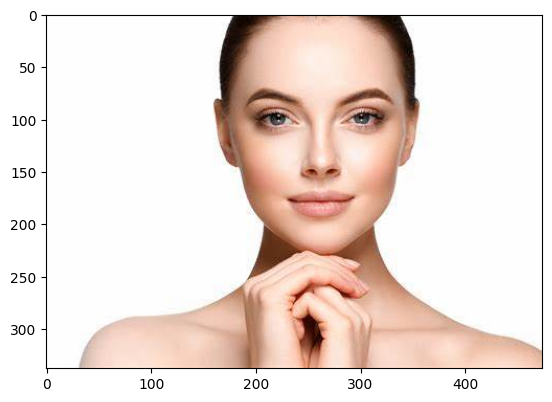

In [511]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [512]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [513]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [514]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [515]:
eyes = eye_cascade.detectMultiScale(gray_img, 1.1, 4)

In [516]:
for x,y,w,h in eyes[2:4]:
    cv2.rectangle(img,(x,y),(x+w,y+h), (0,255,0),2)

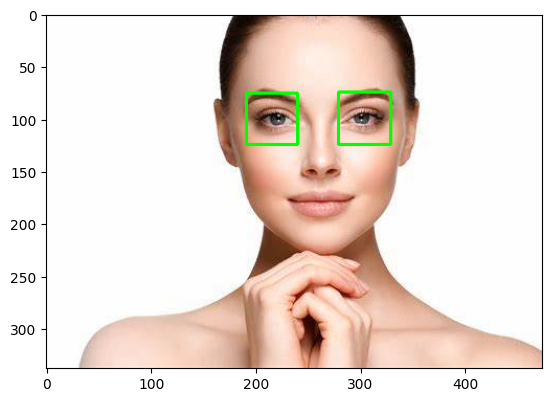

In [517]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [518]:
# Cropping the eye

gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
eyes = eye_cascade.detectMultiScale(gray_img,1.1,4)
for x,y,w,h in eyes[2:4]:
    roi_gray = gray_img[y:y+h,x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes2 = eye_cascade.detectMultiScale(roi_gray)
    if len(eyes2) == 0:
        print('eyes are not detected')
    else:
        for (ex,ey,ew,eh) in eyes2:
            eyes_roi = roi_color[ey:ey+eh,ex:ex+ew]

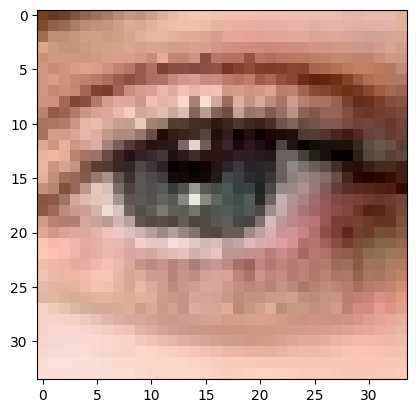

In [519]:
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [520]:
final_img = cv2.resize(eyes_roi, (224,224))

In [521]:
final_img = np.expand_dims(final_img, axis = 0)
final_img = final_img/ 255.0

In [522]:
final_img.shape

(1, 224, 224, 3)

In [523]:
pred = new_model.predict(final_img)

1/1 [==============================] - 0s 216ms/step


In [524]:
pred          # -ve value = open eye, +ve value = closed eye

array([[-41.160034]], dtype=float32)

In [531]:
#Taking Live video from webcam

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    cap = cv2.VideoCapture(1)
if not cap.isOpened():
    raise IOError('Cannot open  Webcam')

while True:
    cbs = 0
    #reading the camera frames
    success, frame = cap.read()
    if not success:
        break
    else:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+ 'haarcascade_eye.xml')
        faces = face_cascade.detectMultiScale(frame, 1.1, 7)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #For drawing rectangle around the face
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0), 2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 3)
            if len(eyes) == 0:
                print('Eyes not detected')
                cbs = 0
                break
            for (ex, ey, ew, eh) in eyes[:2]:
                cbs = 1
                cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
                eyes_roi = roi_color[ey:ey+ eh, ex:ex+ew]
    if cbs == 1 :
        final_image = cv2.resize(eyes_roi,(224,224))
        final_image = np.expand_dims(final_image,axis = 0)
        final_image = final_image/255.0
        predictions = new_model.predict(final_image)
        if (predictions[0][0] < 0):
            status = "Open eyes"
        else:
            status = "Closed eyes"

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, status, (50, 50), font, 3, (0,0,255), 2, cv2.LINE_4)
    cv2.imshow('Driver Drowsiness Detection', frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 193ms/step
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 204ms/step
Eyes not detected
1/1 [==============================] - 0s 190ms/step
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 188ms/step
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 241ms/step
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 204ms/step
Eyes not detected
1/1 [==============================] - 0s 221ms/step
Eyes not detected
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 219ms/step
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
Eyes not detected
1/1 [==============================] - 0s 220ms/step
Eyes not detected
1/1 [==============================] - 0s 220ms/step
Eyes not detected
1/